## Questions to address:
1. Is the business improving or deteriorating?
2. Are there regional differences in the business?
3. Is there seasonality in customer behavior?
4. Is customer quality getting better or worse over time?

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')

In [146]:
#Import data and basic cleaning.
data = pd.read_csv('data_challenge_transactions.csv')
data['transaction_date'] = pd.to_datetime(data['transaction_date']) #Convert to datetime format for easy analysis
data['join_date'] = pd.to_datetime(data['join_date'])
data = data.fillna(method='pad')

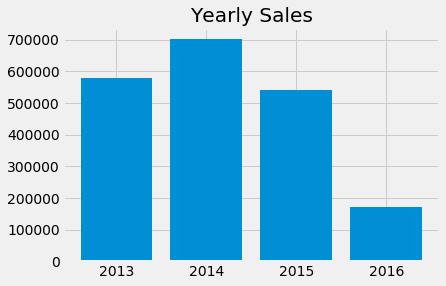

In [147]:
#Plot sales over time.
transaction_years = [data['transaction_date'][i].year for i in range(data.shape[0])]
data['transaction_year'] = transaction_years
yearly_sales = [sum(data[data['transaction_year'] == year]['sales_amount']) for year in range(2013, 2017)]

plt.bar(range(2013,2017),yearly_sales)
plt.title('Yearly Sales')
plt.xticks(range(2013, 2017));

Sales seem to be on a downward trend from 2014-2015, but need to find a way to extrapolate 2016 data for a more complete analysis. I'll use the average proportion of Q1 sales from 2013-2015 to generate an estimate for 2016.

In [148]:
#Get the proportion of sales from Jan-April for 2013-2015 (Called q1 in code for brevity).
is_q1 = lambda date: date.month in range(1, 5) #Checks if a date is in the first quarter
data['q1'] = list(map(is_q1, data['transaction_date'])) #Adds a column of bools to data that check if the date is in q1.
q1_data = data[data['q1'] == True] #Table of sales data from just q1.

q1_sales = [sum(q1_data[q1_data['transaction_year'] == year]['sales_amount']) for year in range(2013, 2017)]
q1_prop = np.average([q/y for q in q1_sales for y in yearly_sales][:3])
q1_prop

0.23125244379758603

In [149]:
estimate_2016 = yearly_sales[3] / q1_prop
estimate_2016

735281.13782369928

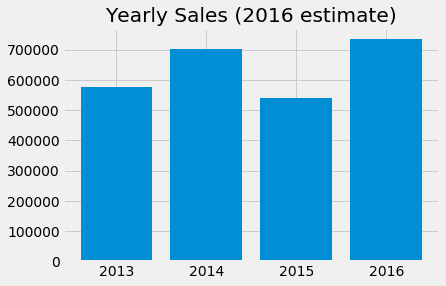

In [150]:
#Plots the yearly sales again but uses the 2016 estimate instead of current sales.
plt.bar(range(2013,2017),yearly_sales[:3] + [estimate_2016])
plt.title('Yearly Sales (2016 estimate)')
plt.xticks(range(2013, 2017));

Seems that Jan-April sales make up 23% of sales on average, which puts 2016 on track to be a rebound year for the company, as it will make more than it did in any of the previous years. This gives a good indiction of general trends for the company, but I'll break down the yearly sales into periods to find seasonal trends.

The dip in 2015 sales is also interesting: it could simply be an anomaly or a slow year for sales in the industry writ large, but there might be a more relevant issue that caused low sales. Will need more fine grain analysis to know for sure.

In [151]:
#Drops the columns created in the last section of analysis to not make the dataframe too messy.
data = data.drop('q1', axis=1)

In [152]:
def quarter(date):
    """Returns the quarter (1,2,3,4) of date."""
    month = date.month
    if month in range(1,4): return 1
    elif month in range(4,7): return 2
    elif month in range(7, 10): return 3
    return 4

data['quarter'] = list(map(quarter, data['transaction_date'])) #Adds the quarter column to data.

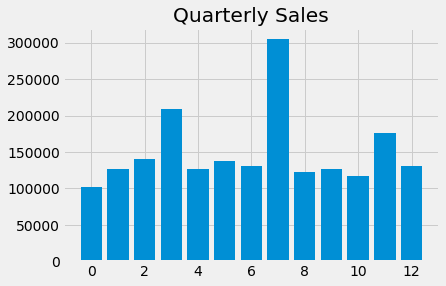

In [153]:
#Break down yearly sales into quarters and plot results.
quarterly_sales = data.groupby(['transaction_year', 'quarter']).sales_amount.agg(sum)
plt.bar(range(13),quarterly_sales[:13]) #Don't include 2016 q2 because we don't have full data for the quarter.
plt.title('Quarterly Sales');

Excuse the poor chart formatting, can't figure out how to include more intuitive x-ticks.

It seems that sales are fairly constant across the first three quarters, and then spikes in the last quarter (holiday season?). This seems to isolate the problem with 2015 better, which is that it had a poor q4 (this also makes the estimate for 2016 a bit more shakey as much of yearly performance comes from the last quarter).

Thoughts relating to the questions thus far:
- Is the business improving or deteriorating - Hard to say with certainty, since much of the sales come from the last quarter. What can be said is that 2016 is on track in terms of its q1 performance, but the company is on overall decline because of its poor 2015 q4 sales.
- Seasonality - Q4 sales make up the largest proportion of quarterly sales in all years, and will often define the difference between a succsessful and poor year. This seasonality is most likely due to the holiday season, though it is hard to say for sure without knowing the specifics of the business.

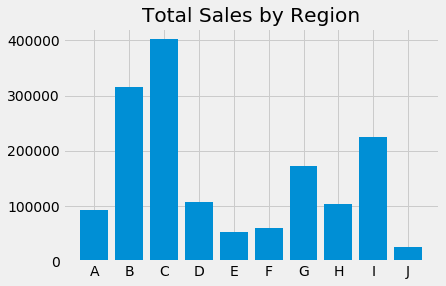

In [154]:
#Plotting how much total sales each region has produced.
regional_sales = data.groupby('region').sales_amount.agg(sum)
plt.bar(regional_sales.index, regional_sales)
plt.title('Total Sales by Region');

Immediately can see that B and C (and G and I to a lesser extent) are the major players when it comes to regional sales. I'll do a finer analysis to see if sales are fairly constant over time with respect to region, or if certain regions perform better at different times.

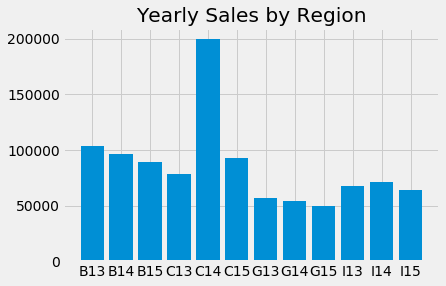

In [155]:
#Now groupby region and year to get a clearer idea of when each region is producing sales
data_temp = data[data['transaction_year'] != 2016] #Exclude 2016 b/c we don't have full data.
region_yearly_sales = data_temp.groupby(['region', 'transaction_year']).sales_amount.agg(sum)
ticks = ['B13', 'B14', 'B15','C13', 'C14', 'C15', 'G13', 'G14', 'G15', 'I13', 'I14', 'I15']
plt.bar(ticks, region_yearly_sales.loc[['B', 'C', 'G', 'I']]) #Only include the regions with substantial sales for simplicity.
plt.title('Yearly Sales by Region');

Interesting, seems that region C performed very well in 2014. This makes me think that it was the main driver for sales during the Q4 of 2014, as that was also an high outlier in terms of sales. If that is the case, it would make the high sales more of an anomaly than a predictor for future success as region C went back to normal sales in 2015. I'll check that now.

Also worth noting that the other major sales regions were all fairly constant over time.

In [156]:
#Checking if region C was the main driver of high sales in Q4 of 2014.
data_14 = data[data['transaction_year'] == 2014]
data_14_q4 = data_14[data_14['quarter'] == 4] #All sales in Q4 of 2014
data_14_q4_c = data_14_q4[data_14_q4['region'] == 'C'] #All sales during that period in region C

q414_sales, q414_c_sales = sum(data_14_q4['sales_amount']), sum(data_14_q4_c['sales_amount'])
q414_c_sales / q414_sales

0.4699803772359685

So it seems that sales during Q4 of 2014 was 'artificially' inflated by region C, which accounted for nearly 50% of total sales. This has interesting implications for many of the points made above ...

The above analysis addresses 3 of the 4 questions (business trajectory, seasonality, regional differences), so I'll now look at customer quality trends.

<Container object of 4999 artists>

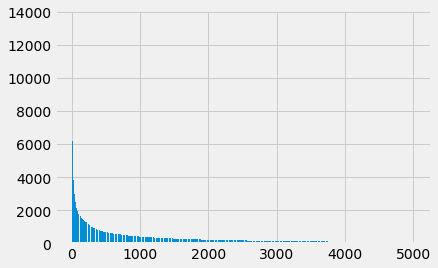

In [171]:
#Plot the total sales by user.
user_sales = data.groupby('user').sales_amount.agg(sum)
user_sales = user_sales.sort_values(ascending=False) #Sort values in descending order
plt.bar(range(1, 5000), user_sales[1:5000]) #Only viewing specific values so the plot is legible.

Interesting, seems the distribution of customer sales follows some Pareto-like distribution, which makes sense given the context. This implies that there are a few customers that make up the majority of sales. For standard Pareto distributions, the proportions would be that 20% of your customers make up 80% of sales. Let's see if that approximation holds for this data set.

In [175]:
top_20_users = user_sales[:2000] #gets the top 20% of customers.
sum(top_20_users) / sum(user_sales)

0.7226013144755368

So it doesn't follow the distribution exactly, but it seems pretty close to the standard Pareto model none the less. The next question is how have these sales distributions changed over time.

In [185]:
#Plot the same customer sale distribution, but now at a yearly level.
user_sales_2013 = data[data['transaction_year'] == 2013].groupby('user').sales_amount.agg(sum).sort_values(ascending=False)
user_sales_2014 = data[data['transaction_year'] == 2014].groupby('user').sales_amount.agg(sum).sort_values(ascending=False)
user_sales_2015 = data[data['transaction_year'] == 2015].groupby('user').sales_amount.agg(sum).sort_values(ascending=False)

<Container object of 5877 artists>

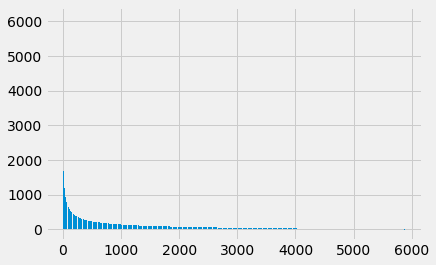

In [182]:
plt.bar(range(len(user_sales_2013)),user_sales_2013)

<Container object of 5412 artists>

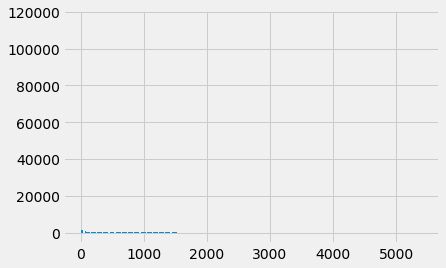

In [183]:
plt.bar(range(len(user_sales_2014)),user_sales_2014)

<Container object of 4676 artists>

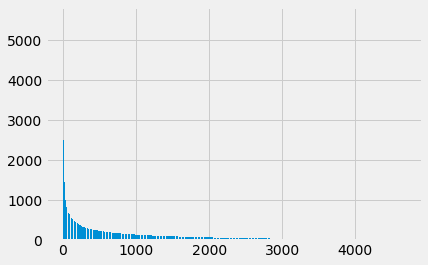

In [184]:
plt.bar(range(len(user_sales_2015)),user_sales_2015)

Both 2013 and 2015 seem fairly consistent with the over customer-sales distribtution, but 2014 seems like a bit of an anomaly. Let's see what's going on.

In [189]:
user_sales_2014.head()

user
864     115190.02
1694      3104.33
28        3004.18
629       2649.14
7214      2494.71
Name: sales_amount, dtype: float64

User 864 is a far outlier in terms of sales, and this is confirms my hypothesis above that sales in 2014 were a bit of an anomaly. I'll make sure that 864's purchases occured in Q4 and was from region C (where the source of the anomaly is) as to confirm this view.

In [192]:
data[data['user'] == 864].head()

,user,transaction_date,sales_amount,join_date,region,transaction_year,quarter
30799,864,2014-12-13,112.03,2014-12-13,C,2014,4
30800,864,2014-12-13,11.68,2014-12-13,C,2014,4
30813,864,2014-12-13,36.58,2014-12-13,C,2014,4
30821,864,2014-12-13,84.79,2014-12-13,C,2014,4
30825,864,2014-12-13,108.52,2014-12-13,C,2014,4


As suspected, all of their purchases came in a 10 day span during Q4 of 2014 from region C. This is definetely an outlier user, so I want to run some of the above analysis again without considering this user.

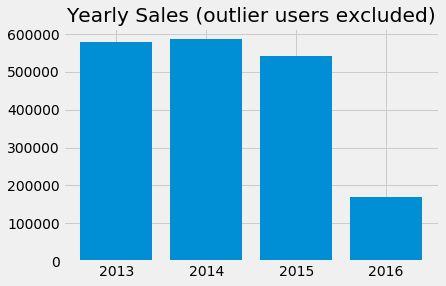

In [193]:
#Generates yearly sales plots without including the outlier user.
data_no_outlier = data[data['user'] != 864]
sales_no_outlier = [sum(data_no_outlier[data_no_outlier['transaction_year'] == year]['sales_amount']) for year in range(2013, 2017)]

plt.bar(range(2013, 2017), sales_no_outlier)
plt.title('Yearly Sales (outlier users excluded)');

I'll also redo my estimate for 2016 to consider a more conservative, albiet more reasonable, estimate of sales.

In [196]:
#Same estimate process as before.
data_no_outlier['q1'] = list(map(is_q1, data_no_outlier['transaction_date'])) #Adds a column of bools to data that check if the date is in q1.
q1_data_no = data_no_outlier[data_no_outlier['q1'] == True] #Table of sales data from just q1.

q1_sales_no = [sum(q1_data_no[q1_data_no['transaction_year'] == year]['sales_amount']) for year in range(2013, 2017)]
q1_prop_no = np.average([q/y for q in q1_sales_no for y in sales_no_outlier][:3])

estimate_2016_no_outlier = sales_no_outlier[3] / q1_prop_no
estimate_2016_no_outlier

/Users/arammoghaddassi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


696267.3747837618

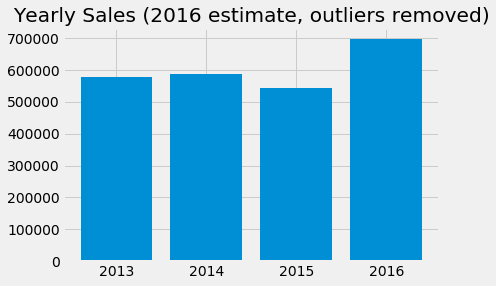

In [198]:
#Draws the yearly sales plot again, but now with the updated 2016 estimate.
plt.bar(range(2013,2017),sales_no_outlier[:3] + [estimate_2016_no_outlier])
plt.title('Yearly Sales (2016 estimate, outliers removed)')
plt.xticks(range(2013, 2017));

So it seems that 2016 is on track to actually have quite a good year, although one shouldn't put too much weight into this estimate.

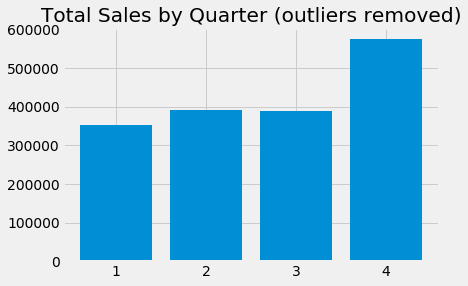

In [206]:
#plotting sales by quarter; think it will be a good figure to have for the write up.
temp_data = data_no_outlier[data_no_outlier['transaction_year'] != 2016]
quartely_sales = temp_data.groupby('quarter').sales_amount.agg(sum)
plt.bar(range(1,5), quartely_sales)
plt.title('Total Sales by Quarter (outliers removed)');

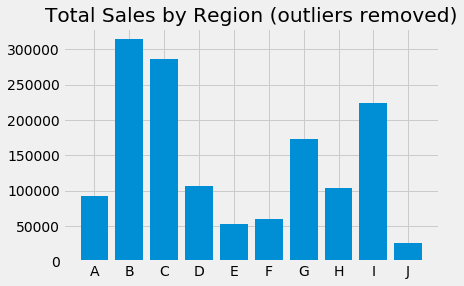

In [209]:
#Plotting how much total sales each region has produced (w/o outlier)
regional_sales_no_outlier = data_no_outlier.groupby('region').sales_amount.agg(sum)
plt.bar(regional_sales_no_outlier.index, regional_sales_no_outlier)
plt.title('Total Sales by Region (outliers removed)');